## Imports

In [38]:
import openml
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import brier_score_loss
import json
import warnings
warnings.filterwarnings("ignore")
import copy


#set random seed
np.random.seed(42)
%run functions.py

## Get datasets

In [39]:
target1 = 'class'
target2 = 'Class'
target3 = 'class'
target4 = 'survived'

In [40]:
# read X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, X4_train, X4_test from csv files
X1_train = pd.read_csv('data/exported/X1_train.csv').drop(columns=['Unnamed: 0'])
X1_test = pd.read_csv('data/exported/X1_test.csv').drop(columns=['Unnamed: 0'])
X2_train = pd.read_csv('data/exported/X2_train.csv').drop(columns=['Unnamed: 0'])
X2_test = pd.read_csv('data/exported/X2_test.csv').drop(columns=['Unnamed: 0'])
X3_train = pd.read_csv('data/exported/X3_train.csv').drop(columns=['Unnamed: 0'])
X3_test = pd.read_csv('data/exported/X3_test.csv').drop(columns=['Unnamed: 0'])
X4_train = pd.read_csv('data/exported/X4_train.csv').drop(columns=['Unnamed: 0'])
X4_test = pd.read_csv('data/exported/X4_test.csv').drop(columns=['Unnamed: 0'])

## Get best default hyperparameters for each dataset

In [41]:
# import best defaults from json
with open('data/best_defaults_random_search.json') as json_file:
    best_defaults = json.load(json_file)

best_defaults

{'lgbm': [{'n_estimators': 461,
   'max_depth': 6,
   'learning_rate': 0.020997940641181385,
   'subsample': 0.8340480910424313,
   'min_child_weight': 5,
   'num_leaves': 4,
   'reg_alpha': 1.2683167745409016,
   'reg_lambda': 9.599077378039295},
  {'AUC': {'credit_g': 0.7408,
    'bank-marketing': 0.6568177638392814,
    'MagicTelescope': 0.8604995265151514,
    'Titanic': 0.8331483094910205},
   'Accuracy': {'credit_g': 0.72,
    'bank-marketing': 0.883,
    'MagicTelescope': 0.821,
    'Titanic': 0.7697974217311234},
   'Brier': {'credit_g': 0.18052918319273423,
    'bank-marketing': 0.09963649943775783,
    'MagicTelescope': 0.13285273951059576,
    'Titanic': 0.1595723595274648}}],
 'rfc': [{'n_estimators': 352,
   'max_depth': 3,
   'min_samples_split': 9,
   'min_samples_leaf': 1,
   'max_features': 0.5546548068068401},
  {'AUC': {'credit_g': 0.7398285714285715,
    'bank-marketing': 0.6672329180822952,
    'MagicTelescope': 0.8533928696689113,
    'Titanic': 0.8425634467833957

## Notes:

* AUC, accuracy and Brier score - metrics to consider while evaluating the models
* random forest, xgboost, lgbm

In [31]:
model_types = [ 'xgb','lgbm', 'rfc', ]
datasets = [[X1_train, X1_test, target1, "credit_g"], [X2_train, X2_test, target2, "bank-marketing"], [X3_train, X3_test, target3, "MagicTelescope"], [X4_train, X4_test, target4, "Titanic"]]

columns = ['Dataset', 'Model', 'Hyperparameters', 'ID', 'Metric', 'Value']
df = pd.DataFrame(columns=columns)
from tqdm.notebook import tqdm
import time
i = 0

AUC_history = dict.fromkeys(model_types, np.array([]))
accuracy_history = dict.fromkeys(model_types, np.array([]))
brier_history = dict.fromkeys(model_types, np.array([]) )

for model_type in model_types:

    for dataset in tqdm(datasets, desc=f"Training {model_type} hyperparams ..."):
        hyperparameter_space, best_defaults_ = get_hyper_space_and_defaults(model_type, best_defaults_model  = best_defaults)
        # print(best_defaults_)
        X_train = dataset[0]
        X_test = dataset[1]
        target = dataset[2]
        dataset = dataset[3]
        y_train = X_train[target]
        y_test = X_test[target]

        X_train = X_train.drop([target], axis=1)
        X_test = X_test.drop([target], axis=1)
        
        for seeds in tqdm(range (50), desc=f"Iterations for {dataset} ..."):
            search_srt = 'Bayes'    
            model, bayes_hyperparameters = train_hyperparam_bayes(X_train, y_train, model_type, default_hypers=best_defaults_, hyper_space=hyperparameter_space)
            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)
            auc = roc_auc_score(y_test, y_pred_proba)
            accuracy = accuracy_score(y_test, y_pred)
            brier = brier_score_loss(y_test, y_pred_proba)
            row = pd.DataFrame.from_dict({
                'Dataset': dataset,
                'Model': model_type,
                'BayesHyperparameters': [bayes_hyperparameters],
                'ID': i,
                'Search': search_srt,
                'Metric': 'AUC',
                'Value': auc
            })
            row2 = pd.DataFrame.from_dict({
                'Dataset': dataset,
                'Model': model_type,
                'BayesHyperparameters': [bayes_hyperparameters],
                'ID': i,
                'Search': search_srt,
                'Metric': 'Accuracy',
                'Value': accuracy
            })
            row3 = pd.DataFrame.from_dict({
                'Dataset': dataset,
                'Model': model_type,
                'BayesHyperparameters': [bayes_hyperparameters],
                'ID': i,
                'Search': search_srt,
                'Metric': 'Brier',
                'Value': brier
            })
            
            df = pd.concat([df, row, row2, row3], ignore_index=True)
            i+=1

            AUC_history[model_type] = np.append(AUC_history[model_type], auc)
            accuracy_history[model_type] = np.append(accuracy_history[model_type], accuracy)
            brier_history[model_type] = np.append(brier_history[model_type], brier)
           



df.to_pickle('data/bayes_search.pkl')




Training xgb hyperparams ...:   0%|          | 0/4 [00:00<?, ?it/s]

Iterations for credit_g ...:   0%|          | 0/50 [00:00<?, ?it/s]

Iterations for bank-marketing ...:   0%|          | 0/50 [00:00<?, ?it/s]

Iterations for MagicTelescope ...:   0%|          | 0/50 [00:00<?, ?it/s]

Iterations for Titanic ...:   0%|          | 0/50 [00:00<?, ?it/s]

Training lgbm hyperparams ...:   0%|          | 0/4 [00:00<?, ?it/s]

Iterations for credit_g ...:   0%|          | 0/50 [00:00<?, ?it/s]

Iterations for bank-marketing ...:   0%|          | 0/50 [00:00<?, ?it/s]

Iterations for MagicTelescope ...:   0%|          | 0/50 [00:00<?, ?it/s]

Iterations for Titanic ...:   0%|          | 0/50 [00:00<?, ?it/s]

Training rfc hyperparams ...:   0%|          | 0/4 [00:00<?, ?it/s]

Iterations for credit_g ...:   0%|          | 0/50 [00:00<?, ?it/s]

Iterations for bank-marketing ...:   0%|          | 0/50 [00:00<?, ?it/s]

Iterations for MagicTelescope ...:   0%|          | 0/50 [00:00<?, ?it/s]

Iterations for Titanic ...:   0%|          | 0/50 [00:00<?, ?it/s]

In [32]:
import pandas as pd
df = pd.read_pickle('data/bayes_search.pkl')
df['BayesHyperparameters']

0       {'gamma': 0.18948799183778545, 'learning_rate'...
1       {'gamma': 0.18948799183778545, 'learning_rate'...
2       {'gamma': 0.18948799183778545, 'learning_rate'...
3       {'gamma': 1.0, 'learning_rate': 1.0, 'max_dept...
4       {'gamma': 1.0, 'learning_rate': 1.0, 'max_dept...
                              ...                        
1795    {'max_depth': 9, 'max_features': 0.34753251366...
1796    {'max_depth': 9, 'max_features': 0.34753251366...
1797    {'max_depth': 3, 'max_features': 0.17218727956...
1798    {'max_depth': 3, 'max_features': 0.17218727956...
1799    {'max_depth': 3, 'max_features': 0.17218727956...
Name: BayesHyperparameters, Length: 1800, dtype: object

In [33]:
df.groupby(['Model', 'Metric']).agg({'Value': ['median', 'std']})

Value          
                  median       std
Model Metric                      
lgbm  AUC       0.778355  0.082095
      Accuracy  0.790607  0.061227
      Brier     0.155331  0.030175
rfc   AUC       0.785459  0.080951
      Accuracy  0.783610  0.065851
      Brier     0.155042  0.031788
xgb   AUC       0.777533  0.083319
      Accuracy  0.791186  0.064116
      Brier     0.152320  0.031038

In [34]:
best_defaults

{'lgbm': [{'n_estimators': 461,
   'max_depth': 6,
   'learning_rate': 0.020997940641181385,
   'subsample': 0.8340480910424313,
   'min_child_weight': 5,
   'num_leaves': 4,
   'reg_alpha': 1.2683167745409016,
   'reg_lambda': 9.599077378039295},
  {'AUC': 0.7728163999613633,
   'Accuracy': 0.7984493554327808,
   'Brier': 0.14314769541713818}],
 'rfc': [{'n_estimators': 352,
   'max_depth': 3,
   'min_samples_split': 9,
   'min_samples_leaf': 1,
   'max_features': 0.5546548068068401},
  {'AUC': 0.7757544514907934,
   'Accuracy': 0.8015013812154697,
   'Brier': 0.14367927220041724}],
 'xgb': [{'n_estimators': 697,
   'max_depth': 7,
   'learning_rate': 0.2640080666387819,
   'subsample': 0.6843558315114833,
   'min_child_weight': 1,
   'max_leaves': 7,
   'gamma': 0.7329678696292486,
   'reg_alpha': 3.8317983424738955,
   'reg_lambda': 0.2856591025699267,
   'nthread': 4},
  {'AUC': 0.7756134458876612,
   'Accuracy': 0.7988701657458563,
   'Brier': 0.142936492532716}]}

In [35]:
df.to_csv('data/bayes_search_results.csv')

## Make DF for convergence plots

In [36]:
metrics_history = {'AUC': AUC_history, 'Accuracy': accuracy_history, 'Brier': brier_history}
# make df from metrics_history
df_history = pd.DataFrame.from_dict(metrics_history)
df_history

temp = pd.DataFrame()
index = 0
datasets_str = ['credit_g', 'bank-marketing', 'MagicTelescope', 'Titanic']
for model_type in model_types:
    for metric in metrics_history.keys():
        # print (df_history.loc[model_type, metric])\
        temp_arr = df_history.loc[model_type, metric]
        for i in range (len (temp_arr)):
            dataset_str = datasets_str[i%4]
            iteration_no = i//4 + 1
            indices_dataset = range(i%4, len(temp_arr), 4)
            temp_arr_dataset = temp_arr[indices_dataset]
            if metric!='Brier':
                row = pd.DataFrame({
                    'Dataset': dataset_str,
                    'Iteration': iteration_no,
                    'Model': model_type,
                    'Metric': metric,
                    'Value': np.max(temp_arr_dataset[0:i+1])
                }, index=[index])
            else:
                row = pd.DataFrame({
                    'Dataset': dataset_str,
                    'Iteration': iteration_no,
                    'Model': model_type,
                    'Metric': metric,
                    'Value': np.min(temp_arr_dataset[0:i+1])
                }, index=[index])
            index += 1
            temp = pd.concat([temp, row], ignore_index=True)
        

temp


,Dataset,Iteration,Model,Metric,Value
0,credit_g,1,xgb,AUC,0.739686
1,bank-marketing,1,xgb,AUC,0.736571
2,MagicTelescope,1,xgb,AUC,0.738619
3,Titanic,1,xgb,AUC,0.728724
4,credit_g,2,xgb,AUC,0.739686
...,...,...,...,...,...
1795,Titanic,49,rfc,Brier,0.099603
1796,credit_g,50,rfc,Brier,0.100045
1797,bank-marketing,50,rfc,Brier,0.099353
1798,MagicTelescope,50,rfc,Brier,0.100195


## Make convergence plots

             Dataset  Iteration Model Metric     Value
0           credit_g          1   xgb    AUC  0.739686
1     bank-marketing          1   xgb    AUC  0.736571
2     MagicTelescope          1   xgb    AUC  0.738619
3            Titanic          1   xgb    AUC  0.728724
4           credit_g          2   xgb    AUC  0.739686
...              ...        ...   ...    ...       ...
1395         Titanic         49   rfc    AUC  0.859770
1396        credit_g         50   rfc    AUC  0.859984
1397  bank-marketing         50   rfc    AUC  0.861080
1398  MagicTelescope         50   rfc    AUC  0.860532
1399         Titanic         50   rfc    AUC  0.859770

[600 rows x 5 columns]
(150, 5) (150, 5) (150, 5) (150, 5)


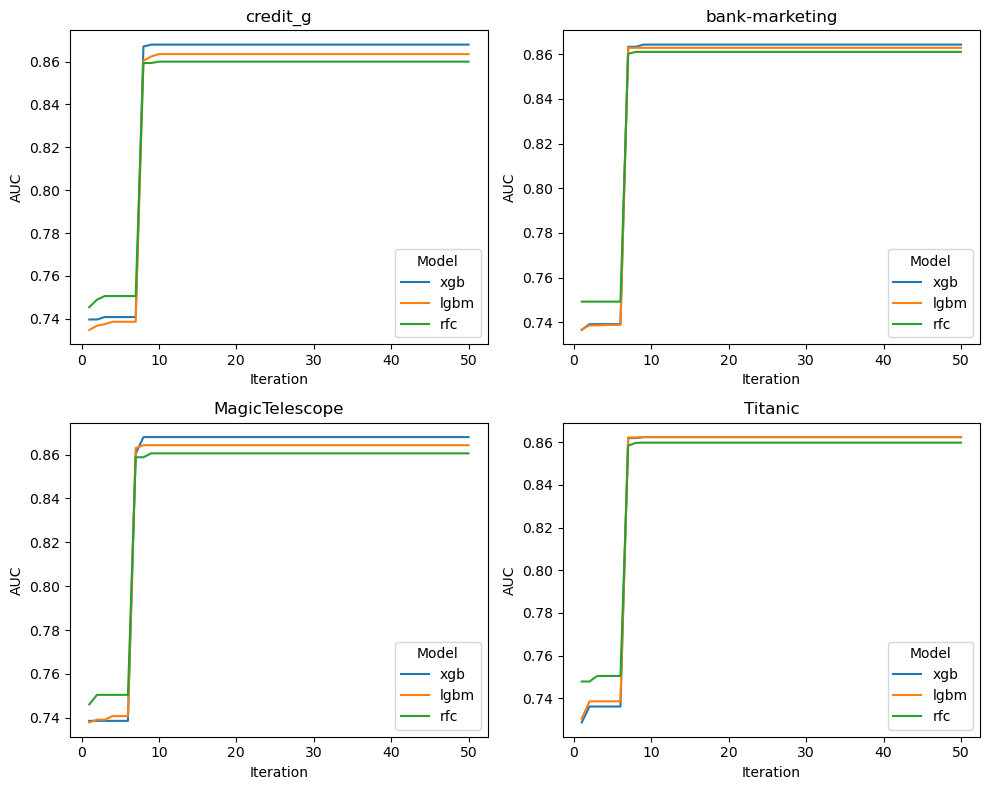

             Dataset  Iteration Model    Metric  Value
200         credit_g          1   xgb  Accuracy  0.722
201   bank-marketing          1   xgb  Accuracy  0.712
202   MagicTelescope          1   xgb  Accuracy  0.720
203          Titanic          1   xgb  Accuracy  0.722
204         credit_g          2   xgb  Accuracy  0.730
...              ...        ...   ...       ...    ...
1595         Titanic         49   rfc  Accuracy  0.884
1596        credit_g         50   rfc  Accuracy  0.883
1597  bank-marketing         50   rfc  Accuracy  0.883
1598  MagicTelescope         50   rfc  Accuracy  0.883
1599         Titanic         50   rfc  Accuracy  0.884

[600 rows x 5 columns]
(150, 5) (150, 5) (150, 5) (150, 5)


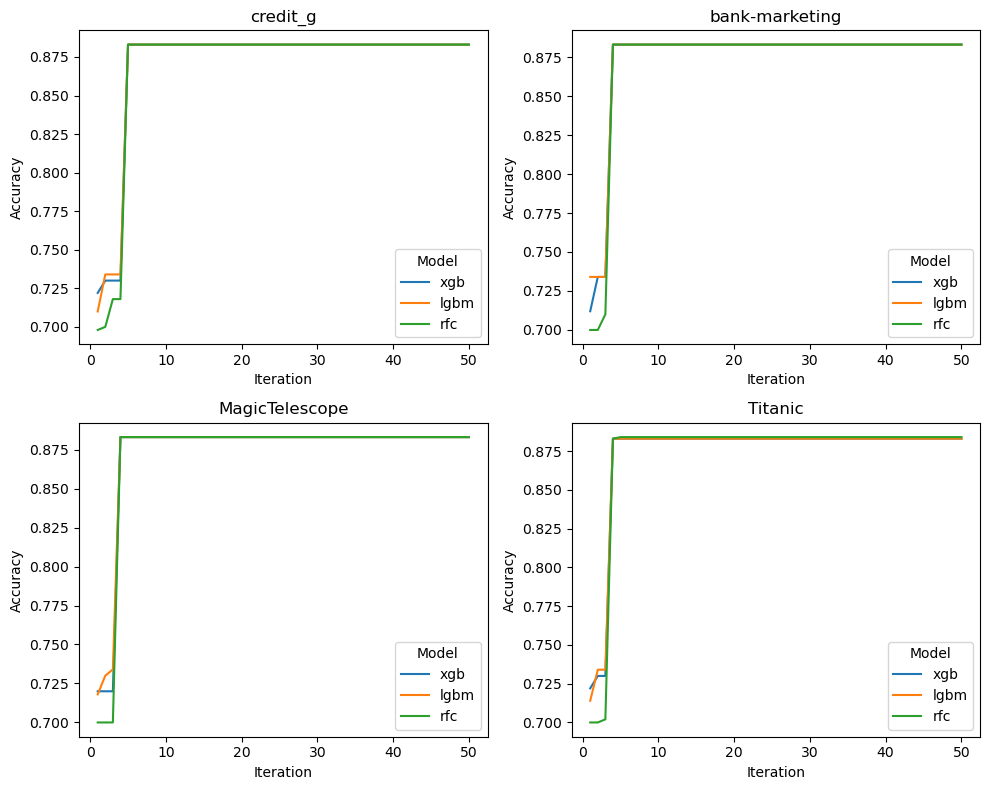

             Dataset  Iteration Model Metric     Value
400         credit_g          1   xgb  Brier  0.180897
401   bank-marketing          1   xgb  Brier  0.181682
402   MagicTelescope          1   xgb  Brier  0.180067
403          Titanic          1   xgb  Brier  0.182075
404         credit_g          2   xgb  Brier  0.180372
...              ...        ...   ...    ...       ...
1795         Titanic         49   rfc  Brier  0.099603
1796        credit_g         50   rfc  Brier  0.100045
1797  bank-marketing         50   rfc  Brier  0.099353
1798  MagicTelescope         50   rfc  Brier  0.100195
1799         Titanic         50   rfc  Brier  0.099603

[600 rows x 5 columns]
(150, 5) (150, 5) (150, 5) (150, 5)


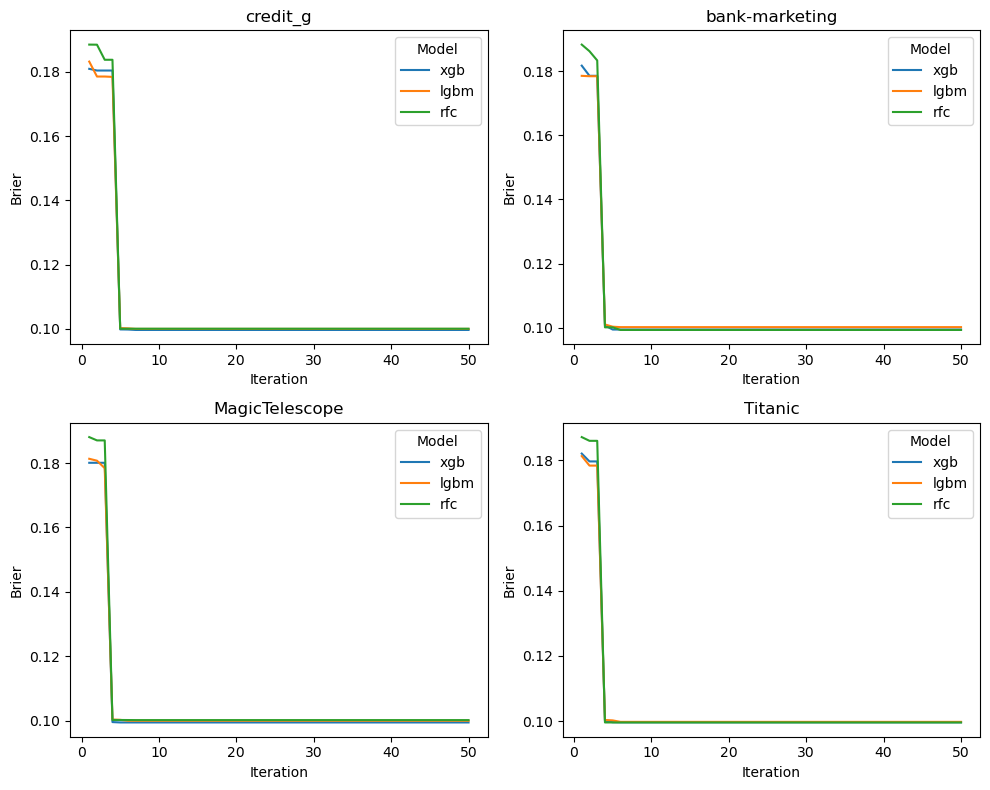

In [37]:
# plot history of metrics grouped by model type as lines from temp

import matplotlib.pyplot as plt
import seaborn as sns

datasets  = ['credit_g', 'bank-marketing', 'MagicTelescope', 'Titanic']

for metric in ['AUC', 'Accuracy', 'Brier']:
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    temp2 = temp[temp['Metric'] == metric]
    print(temp2)
    # 4 plots 2x2
    temp_credit = temp2[temp2['Dataset'] == 'credit_g']
    temp_bank = temp2[temp2['Dataset'] == 'bank-marketing']
    temp_magic = temp2[temp2['Dataset'] == 'MagicTelescope']
    temp_titanic = temp2[temp2['Dataset'] == 'Titanic']
    print(temp_credit.shape, temp_bank.shape, temp_magic.shape, temp_titanic.shape)
    

    plt.rcParams['figure.figsize'] = [8, 6]
    sns.lineplot(data=temp_credit, x='Iteration', y='Value', hue='Model', ax=axs[0, 0])
    # set titles
    axs[0, 0].set_title('credit_g')
    axs[0, 0].set_xlabel('Iteration')
    axs[0, 0].set_ylabel(metric)
   


    sns.lineplot(data=temp_bank, x='Iteration', y='Value', hue='Model', ax=axs[0, 1])
    # set titles
    axs[0, 1].set_title('bank-marketing')
    axs[0, 1].set_xlabel('Iteration')
    axs[0, 1].set_ylabel(metric)
    


    sns.lineplot(data=temp_magic, x='Iteration', y='Value', hue='Model', ax=axs[1, 0])
    # set titles
    axs[1, 0].set_title('MagicTelescope')
    axs[1, 0].set_xlabel('Iteration')
    axs[1, 0].set_ylabel(metric)
    


    sns.lineplot(data=temp_titanic, x='Iteration', y='Value', hue='Model', ax=axs[1, 1])
    # set titles
    axs[1, 1].set_title('Titanic')
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel(metric)
    

    plt.tight_layout()
    

    # save figure
    plt.savefig(f'plots/{metric}_history_bayes_search.png')
    plt.show()
  

        